In [87]:
import sys

import pandas as pd # type: ignore
import numpy as np # type: ignore
from scipy import stats

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

import networkx as nx # type: ignore
import graphviz # type: ignore

import statsmodels.formula.api as smf # type: ignore
import statsmodels.api # type: ignore
from statsmodels.miscmodels.ordinal_model import OrderedModel # type: ignore

from dowhy import CausalModel, gcm # type: ignore
from dowhy.gcm.shapley import ShapleyConfig, ShapleyApproximationMethods # type: ignore

import warnings
warnings.filterwarnings("ignore")

In [88]:
df = pd.read_csv("../data/processed/data.csv")

In [89]:
# Impute missing values
df.rename(columns={'Product_price': 'revenue'}, inplace=True) 
df['Product_price'] = df['revenue'] + df['freight_value']
df['Product_weight_kg'] = df['Product_weight_kg'].fillna(df['Product_weight_kg'].mean())
df['distance_km'] = df['distance_km'].fillna(df['distance_km'].mean())
df['Product_size'] = df['Product_size'].fillna(df['Product_size'].mean())
# df['customer_avg_score'] = df['customer_avg_score'].fillna(df['customer_avg_score'].mean())
df['No_photos'] = df['No_photos'].fillna(df['No_photos'].mean())
df['Product_price'] = df['Product_price'].fillna(df['Product_price'].mean())
df['freight_value'] = df['freight_value'].fillna(df['freight_value'].mean())
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Rating'] = df['Rating'].round()
df['Product_category'] = df['Product_category'].fillna(df['Product_category'].mode()[0])
df['revenue'] = df['revenue'].fillna(df['revenue'].mean())

**DAG**

In [9]:
mapping_dict = {'Rating': 'discrete',
                'Product_category_encoded': 'categorical',
                'freight_value': 'continuous',
                'distance_km': 'continuous' ,
                'season': 'categorical' ,
                'is_delivery_late': 'categorical'}

# nodes
nodes_list = [
'Rating',
'Product_category_encoded',
'freight_value',
'distance_km',
'season',
'is_delivery_late'
]
# edges
edges_list = [
    ('season', 'Rating'),
    ('season', 'is_delivery_late'),
    ('season', 'Product_category_encoded'),
    ('is_delivery_late', 'Rating'),
    ('Product_category_encoded', 'is_delivery_late'),
    ('Product_category_encoded', 'Rating'),
    ('Product_category_encoded', 'freight_value'),
    ('Product_category_encoded', 'Rating'),
    ('freight_value', 'is_delivery_late'),
    ('freight_value', 'Rating'),
    ('distance_km', 'freight_value'),
    ('distance_km', 'Rating'),
]

# Graph
G = nx.DiGraph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

---
#### Causal Mechanism Assignment

**Structural Causal Model (SCM)** 

limits mechanisms to deterministic functional causal models of the form $X_i = f_i(\text{PA}_i, N_i)$, where $PA_i$ represents parent nodes and $N_i$ denotes unobserved noise.

While $N_i$ is unobserved during model fitting, it can be used as input when provided.

**Root Nodes**
- **Empirical Distribution**: Random sampling from provided data

**Non-Root Nodes**

1. **Continuous Data - Additive Noise Models (ADM)**
   - $X_i = f(PA_i) + N_i$
   - Selection: Minimizing mean squared error

2. **Discrete Data - Discrete ADM**
   - Like continuous ADM, but f returns discrete values
   - Evaluation: Mean Squared Error (MSE)

3. **Categorical Data - Classifier-based Model**
   - $X_i = f(PA_i, N_i)$, where $N_i$ ~ U[0,1]
   - Selection: Optimizing F1 score


[Estimating Causal Effect Using GCM](https://www.pywhy.org/dowhy/v0.11.1/user_guide/causal_tasks/estimating_causal_effects/effect_estimation_with_gcm.html)

In [10]:
rng = np.random.default_rng()
causal_model = gcm.StructuralCausalModel(G)

for node in G.nodes:

    # grabbing node's parents if any
    parents = set(G.predecessors(node))

    # if node is a root
    if len(parents) == 0:
        random_mean = rng.normal()
        random_scale = abs(rng.normal())
        emp_dist = gcm.ScipyDistribution(stats.norm, loc=random_mean, scale=random_scale)
        causal_model.set_causal_mechanism(node=node, mechanism=emp_dist)

    else:
        node_type = mapping_dict[node]
        if node_type == 'discrete':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_regressor()))
        elif node_type == 'categorical':
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_hist_gradient_boost_classifier())) 
        else:
            print(node_type + "||" + node)
            causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(prediction_model=gcm.ml.create_linear_regressor())) 

gcm.fit(causal_model, df)


discrete||Rating
categorical||Product_category_encoded
continuous||freight_value
categorical||is_delivery_late


Fitting causal mechanism of node is_delivery_late: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it]        


In [11]:
sample_mean_list = []
num_iter = 100

for i in range(num_iter):
    random_sample = gcm.draw_samples(causal_model=causal_model, num_samples=100000)
    treatment = random_sample[random_sample['is_delivery_late'] == 1]['Rating'].mean()
    control = random_sample[random_sample['is_delivery_late'] == 0]['Rating'].mean()
    ate = treatment - control
    sample_mean_list.append(ate)

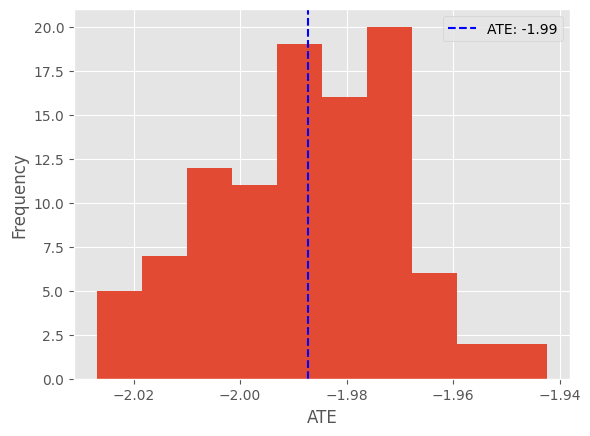

In [12]:
plt.style.use('ggplot')
plt.hist(sample_mean_list)
plt.axvline(np.mean(sample_mean_list), linestyle='dashed', color='blue', label=f'ATE: {round(np.mean(sample_mean_list),2)}')
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Quantifying Intrinsic Causal Influence

In [21]:
iccs_late_deliveries = gcm.intrinsic_causal_influence(causal_model=causal_model, 
                               target_node='Rating',
                               num_training_samples=10000,
                               num_samples_randomization=100,
                               shapley_config=ShapleyConfig(approximation_method=ShapleyApproximationMethods.PERMUTATION, num_permutations=100)
                               )

Evaluate set function: 62it [00:05, 12.15it/s]


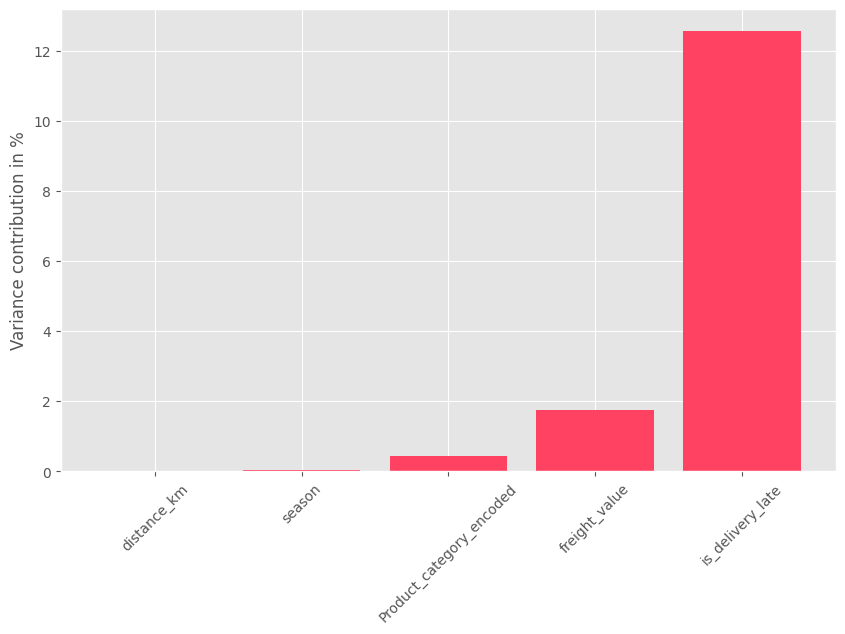

In [22]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

plt.figure(figsize=(10,6))
plt.bar(list(convert_to_percentage(iccs_late_deliveries).keys())[:-1], list(convert_to_percentage(iccs_late_deliveries).values())[:-1], color='#FF4162')
plt.ylabel("Variance contribution in %")
plt.xticks(rotation=45)
plt.show()

***Fine-tuning***

is_late_delivery = f(Product Category, Freight Value, Season) + N

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report

In [23]:
temp_df = df[['order_purchase_timestamp', 'Product_category_encoded', 'freight_value', 'season', 'is_delivery_late']]
temp_df.head()

,order_purchase_timestamp,Product_category_encoded,freight_value,season,is_delivery_late
0,2017-09-26 22:17:05,31,21.02,9,0
1,2017-10-18 08:16:34,31,21.02,10,0
2,2017-10-12 13:33:22,31,21.02,10,0
3,2017-09-03 08:06:30,40,33.08,9,0
4,2017-09-03 08:06:30,40,33.08,9,0


In [91]:
X = temp_df[['Product_category_encoded', 'freight_value', 'season']]
y = temp_df['is_delivery_late']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3)


In [36]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print("val set ", f1_score(y_val, y_val_pred))
print("test set ", f1_score(y_test, y_test_pred))



val set  0.0
test set  0.0


In [58]:
rf_model = RandomForestClassifier(class_weight='balanced')

rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
print("val set ", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))



val set  0.2633654688869413
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     26737
           1       0.22      0.32      0.26      1858

    accuracy                           0.88     28595
   macro avg       0.59      0.62      0.60     28595
weighted avg       0.90      0.88      0.89     28595



In [65]:
# Predict probabilities
y_probs = rf_model.predict_proba(X_val)[:, 1]
threshold = 0.55 
y_val_pred_adjusted = (y_probs >= threshold).astype(int)

print("val set ", f1_score(y_val, y_val_pred_adjusted))
print(classification_report(y_val, y_val_pred_adjusted))

val set  0.2678440029433407
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     26737
           1       0.25      0.29      0.27      1858

    accuracy                           0.90     28595
   macro avg       0.60      0.62      0.61     28595
weighted avg       0.90      0.90      0.90     28595



In [67]:
rf_model = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
}

stratified_kfold = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=stratified_kfold,  
                           n_jobs=-1,  
                           verbose=3)  

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.229 total time=   1.2s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.256 total time=   1.3s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.242 total time=   1.3s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.241 total time=   2.5s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.244 total time=   1.2s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.257 total time=   2.7s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.227 total time=   2.7s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.234 total time=   1.3s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_sp

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [20, 30], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=3)

In [68]:
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val)

print("F1: ", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


F1:  0.272434073230886
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     26737
           1       0.21      0.39      0.27      1858

    accuracy                           0.87     28595
   macro avg       0.58      0.64      0.60     28595
weighted avg       0.91      0.87      0.88     28595



In [70]:
# Make predictions on the validation set
y_test_pred = best_model.predict(X_test)

print("F1: ", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

F1:  0.26553542765420773
              precision    recall  f1-score   support

           0       0.95      0.90      0.93     22262
           1       0.21      0.37      0.27      1567

    accuracy                           0.87     23829
   macro avg       0.58      0.63      0.60     23829
weighted avg       0.90      0.87      0.88     23829



---

In [96]:
temp_df['order_purchase_timestamp'] = pd.to_datetime(temp_df['order_purchase_timestamp'])
temp_df['dow'] = temp_df['order_purchase_timestamp'].dt.day_of_week
temp_df['hour'] = temp_df['order_purchase_timestamp'].dt.hour
temp_df['is_summer'] = temp_df['season'].isin([12,1,23]).astype(int)
temp_df['is_christmas'] = temp_df['season'].isin([1]).astype(int)
temp_df['is_carnaval'] = temp_df['season'].isin([2]).astype(int)

X = temp_df[['Product_category_encoded', 'freight_value', 'season', 'dow', 'hour', 'is_summer', 'is_christmas', 'is_carnaval']]
y = temp_df['is_delivery_late']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3)


In [97]:
rf_model = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4],
}

stratified_kfold = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=stratified_kfold,  
                           n_jobs=-1,  
                           verbose=3)  

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.219 total time=   1.4s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.241 total time=   1.4s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.223 total time=   1.5s
[CV 3/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.246 total time=   2.9s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.228 total time=   3.0s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.222 total time=   2.9s
[CV 1/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.218 total time=   1.4s
[CV 2/3] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.228 total time=   1.4s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [20, 30], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=3)

In [98]:
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_model.predict(X_val)

print("F1: ", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


F1:  0.2781667727562062
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     26736
           1       0.34      0.24      0.28      1859

    accuracy                           0.92     28595
   macro avg       0.64      0.60      0.62     28595
weighted avg       0.91      0.92      0.91     28595



---

In [ ]:
import dowhy.gcm.ml.prediction_model


class MyCustomModel(gcm.ml.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient
    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass
    def predict(self, X):
        return self.coefficient * X
    def clone(self):
        return MyCustomModel(self.coefficient)